<a href="https://colab.research.google.com/github/azrazainol/STQD6324_Assignment_02/blob/main/STQD6324_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2006 Flight Data**

This analysis provides insights on airline performance based on flight data from 2006. The insights are extracted using Hive (SQL) and is analysed below through visualisation.

When purchasing airline tickets, people would most likely go for times or airlines with low cancellation and delay rates. Given a situation where one wants to purchase tickets for a vacation where time can be planned beforehand but may not be changed after the decision is made, seasons or times that have low cancellation rates are likely preferred to avoid the possibility of having to cancel the whole vacation as rescheduling the vacation may be impossible. Due to the that, at the end of the analysis, a regression model is trained using the data to find whether a certain time may be suitable or not to have a vacation so that flight cancellations may be avoided.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
flights = pd.read_csv('/content/drive/MyDrive/hdfs/2006.csv')
flights

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,27,12,0,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141917,2006,12,29,5,1246.0,1249,1452.0,1459,DL,1675,...,6,12,0,NaN,0,0,0,0,0,0
7141918,2006,12,29,5,1225.0,1155,2033.0,1931,DL,1676,...,12,35,0,NaN,0,30,0,32,0,0
7141919,2006,12,29,5,2118.0,2115,2254.0,2241,DL,1676,...,9,27,0,NaN,0,0,0,0,0,0
7141920,2006,12,29,5,2122.0,2127,2209.0,2223,DL,1677,...,5,21,0,NaN,0,0,0,0,0,0


In [26]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141922 entries, 0 to 7141921
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay      

In [27]:
flights['CancellationCode'].value_counts()

CancellationCode
A    55655
B    37913
C    28209
D      157
Name: count, dtype: int64

In [55]:
flights['ArrDelay'].value_counts()

ArrDelay
-5.0       252676
 0.0       234953
-10.0      218209
-7.0       217868
-6.0       211016
            ...  
 1008.0         1
 1124.0         1
 958.0          1
-129.0          1
 655.0          1
Name: count, Length: 1136, dtype: int64

In [53]:
flights['Origin'].value_counts()

Origin
ATL    407971
ORD    373736
DFW    301163
LAX    233788
DEN    232476
        ...  
OAJ        62
TTN        51
HKY        42
HVN         3
CKB         1
Name: count, Length: 289, dtype: int64

In [54]:
flights['Dest'].value_counts()

Dest
ATL    404829
ORD    373799
DFW    301312
LAX    233900
DEN    232365
        ...  
PUB         2
LBF         1
LAR         1
SUX         1
RCA         1
Name: count, Length: 296, dtype: int64

In [52]:
flights['UniqueCarrier'].value_counts()

UniqueCarrier
WN    1099321
AA     643597
MQ     550088
OO     548109
DL     506086
US     504844
UA     500008
XE     441470
NW     432880
CO     309389
YV     304764
OH     278099
EV     273143
FL     237645
AS     159404
B6     155732
F9      90181
HA      52173
AQ      35387
TZ      19602
Name: count, dtype: int64

In [29]:
# pd.read_csv('')

# 1
ot_hour = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_timeOfDay.csv')

ot_day = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_dayOfWeek.csv')
ot_month = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_month.csv')
ot_season = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_season.csv')

# 2
delay_factor = pd.read_csv('/content/drive/MyDrive/hdfs/2_delay_factor.csv')

# 3
cancellation_factor = pd.read_csv('/content/drive/MyDrive/hdfs/3_cancellation_code.csv')

# 4
frequent_cancellation = pd.read_csv('/content/drive/MyDrive/hdfs/4_flightnum_cancellation.csv')
frequent_delay = pd.read_csv('/content/drive/MyDrive/hdfs/4_flightnum_delay_count.csv')

# extra insights


In [30]:
rename_dict = {
    'avg_weatherdelay': 'Weather Delay',
    'avg_nasdelay': 'NAS Delay',
    'avg_securitydelay': 'Security Delay',
    'avg_lateaircraftdelay': 'Late Aircraft Delay',
    'avg_carrierdelay': 'Carrier Delay'}

delay_factor = delay_factor.rename(columns=rename_dict)

# delay_factor = delay_factor.melt(var_name='Delay Type', value_name='Average Delay (minutes)')
delay_factor = delay_factor.T.reset_index()
delay_factor.columns = ['Delay Type', 'Average Delay (minutes)']
delay_factor = delay_factor.sort_values(by='Average Delay (minutes)', ascending=False)

In [31]:
cancellation_mapping = {
    'A': 'carrier',
    'B': 'weather',
    'C': 'NAS',
    'D': 'security'}

cancellation_factor['cancellation_reason'] = cancellation_factor['cancellationcode'].map(cancellation_mapping)

In [32]:
top_20_cancellations = frequent_cancellation.head(20)
top_20_delays = frequent_delay.head(20)
top_20_avg_delays = frequent_delay.sort_values(by='avg_arrdelay', ascending=False).head(20)

<ipython-input-45-677476df0969>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ot_season, x='avg_arrdelay', y='season', palette='Dark2')


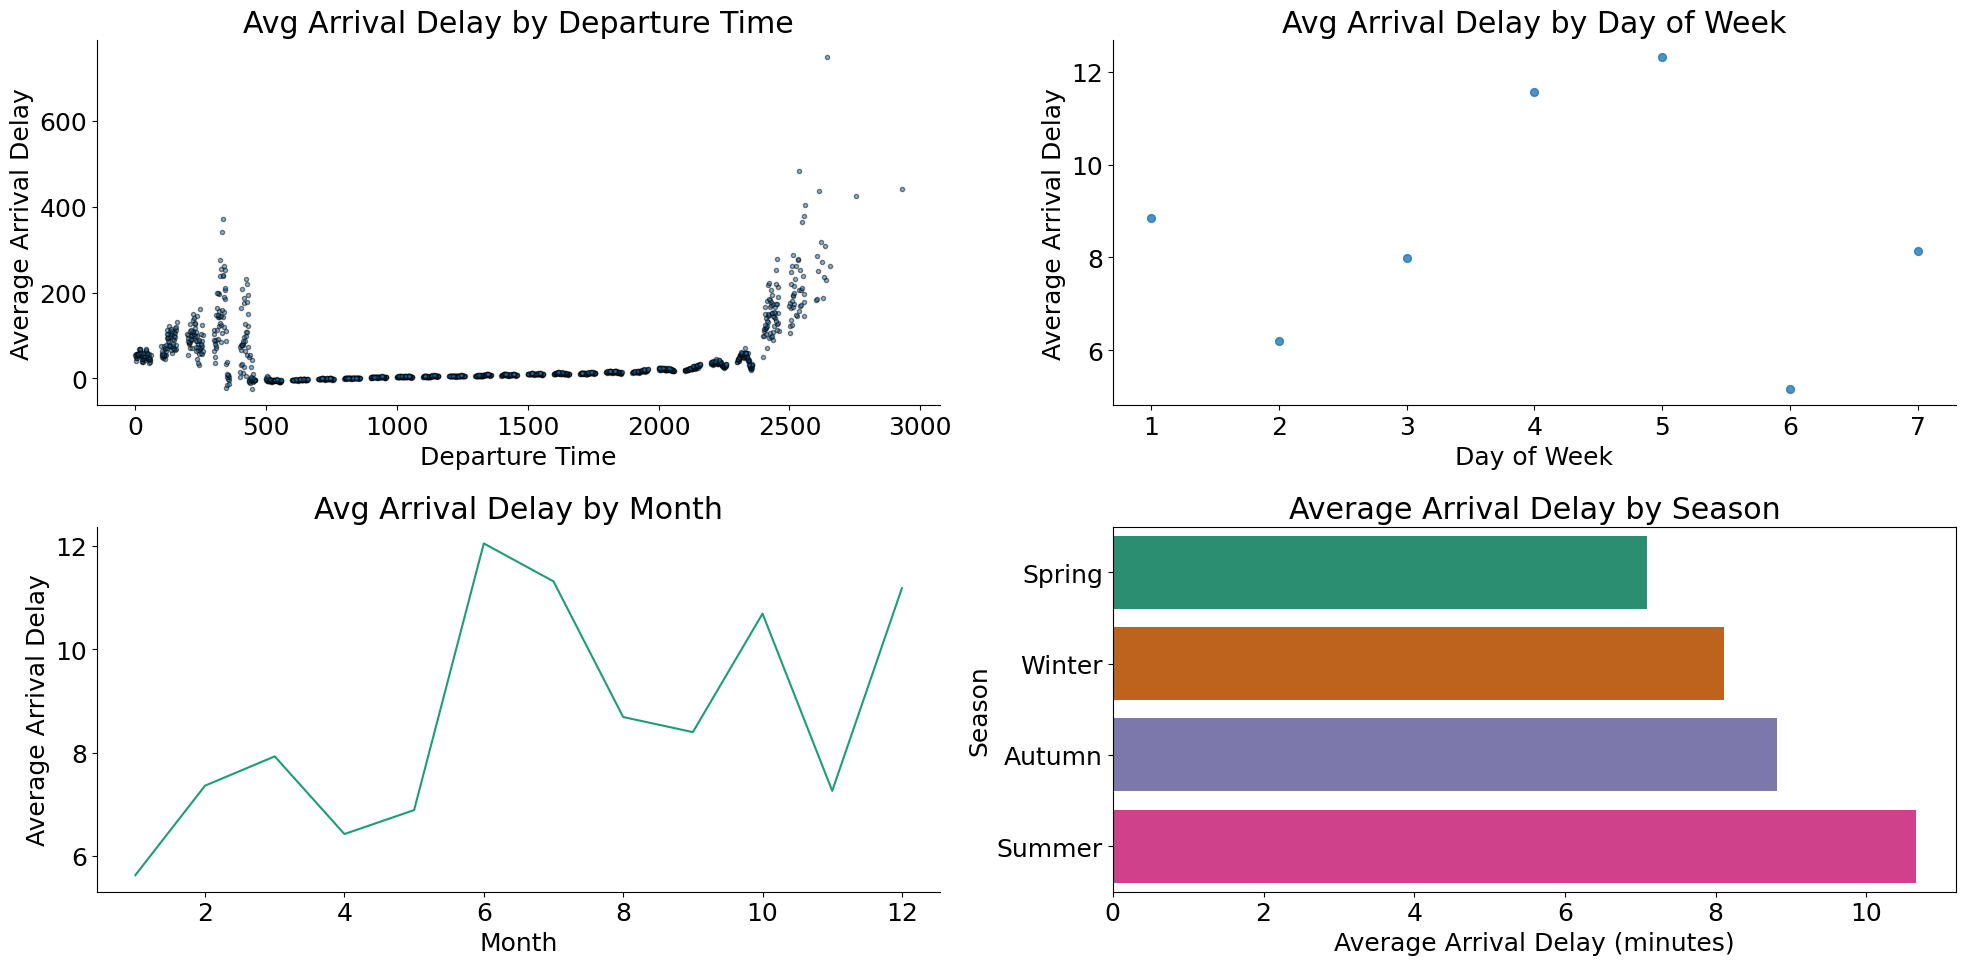

In [45]:
# Set up the plot size and grid
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Plot 1: Average Arrival Delay by Departure Time
plt.subplot(2, 2, 1)
ot_hour.plot(kind='scatter', x='deptime', y='avg_arrdelay', s=35, alpha=.5, marker='.', facecolor='white',  edgecolor='black', ax=plt.gca())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Average Arrival Delay')

# Plot 2: Average Arrival Delay by Day of Week
plt.subplot(2, 2, 2)
ot_day.plot(kind='scatter', x='dayofweek', y='avg_arrdelay', s=32, alpha=.8, ax=plt.gca())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Arrival Delay')

# Plot 3: Average Arrival Delay by Month
plt.subplot(2, 2, 3)
df_sorted = ot_month.sort_values('month', ascending=True)
palette = list(sns.color_palette('Dark2'))
plt.plot(df_sorted['month'], df_sorted['avg_arrdelay'], label='Avg Arrival Delay', color=palette[0])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay')

# Plot 4: Average Arrival Delay by Season
plt.subplot(2, 2, 4)
sns.barplot(data=ot_season, x='avg_arrdelay', y='season', palette='Dark2')
plt.title('Average Arrival Delay by Season')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Season')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show();

<ipython-input-34-5e11e031def2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=delay_factor, y='Average Delay (minutes)', x='Delay Type', palette='viridis')
<ipython-input-34-5e11e031def2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=cancellation_factor, x='cancellation_reason', y='cancellation_count', palette='viridis')


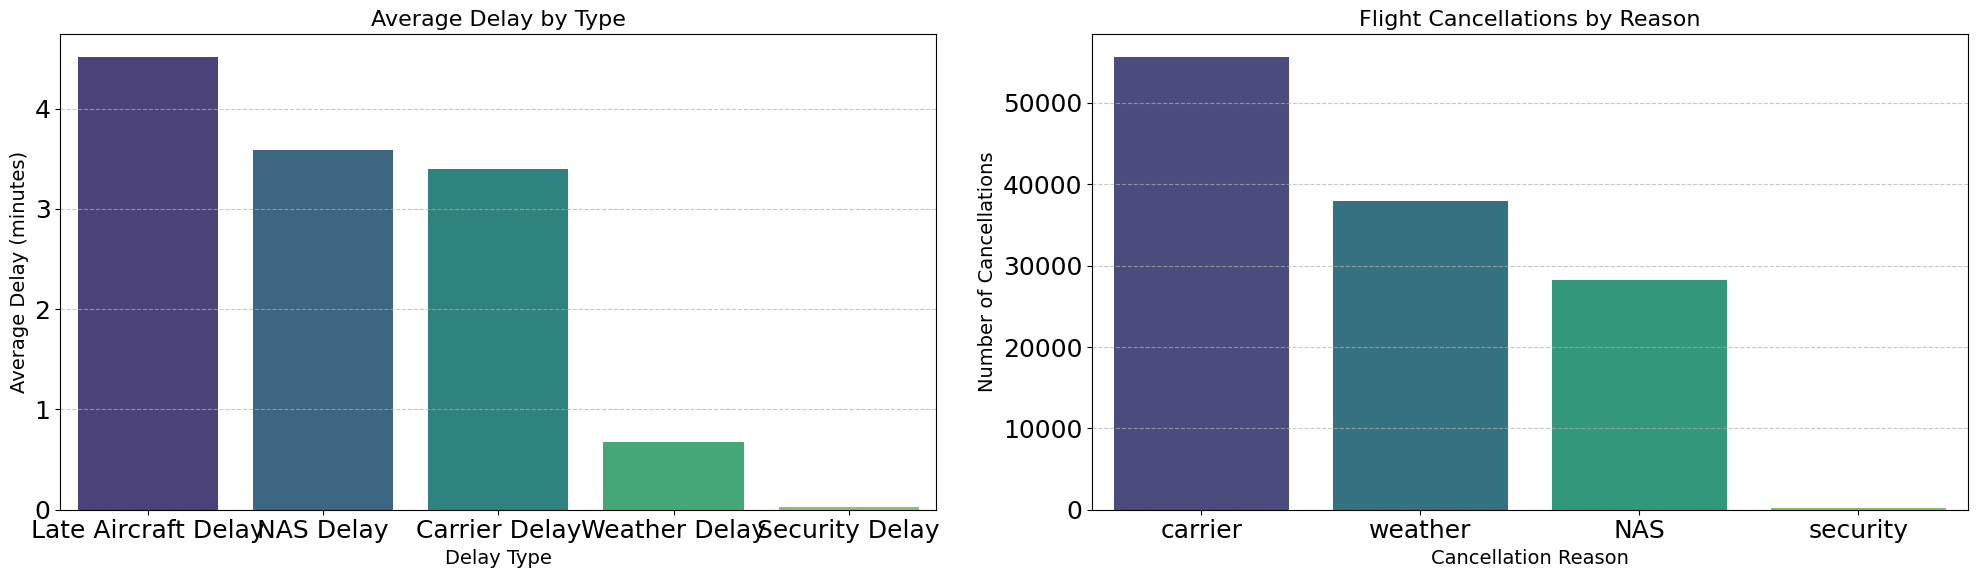

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 14, 'lines.markersize': 10})

# Plot Average Delay by Type
sns.barplot(ax=axes[0], data=delay_factor, y='Average Delay (minutes)', x='Delay Type', palette='viridis')
axes[0].set_title('Average Delay by Type', fontsize=16)
axes[0].set_ylabel('Average Delay (minutes)', fontsize=14)
axes[0].set_xlabel('Delay Type', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Flight Cancellations by Reason
sns.barplot(ax=axes[1], data=cancellation_factor, x='cancellation_reason', y='cancellation_count', palette='viridis')
axes[1].set_title('Flight Cancellations by Reason', fontsize=16)
axes[1].set_xlabel('Cancellation Reason', fontsize=14)
axes[1].set_ylabel('Number of Cancellations', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

<ipython-input-60-1ba8178df62c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_avg_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
<ipython-input-60-1ba8178df62c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
<ipython-input-60-1ba8178df62c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_avg_delays, y='delay_count', x='flightnum', palette='viridis')
<ipython-input-60-1ba8178df62c>:23: FutureWarning: 

Passing `palette` without 

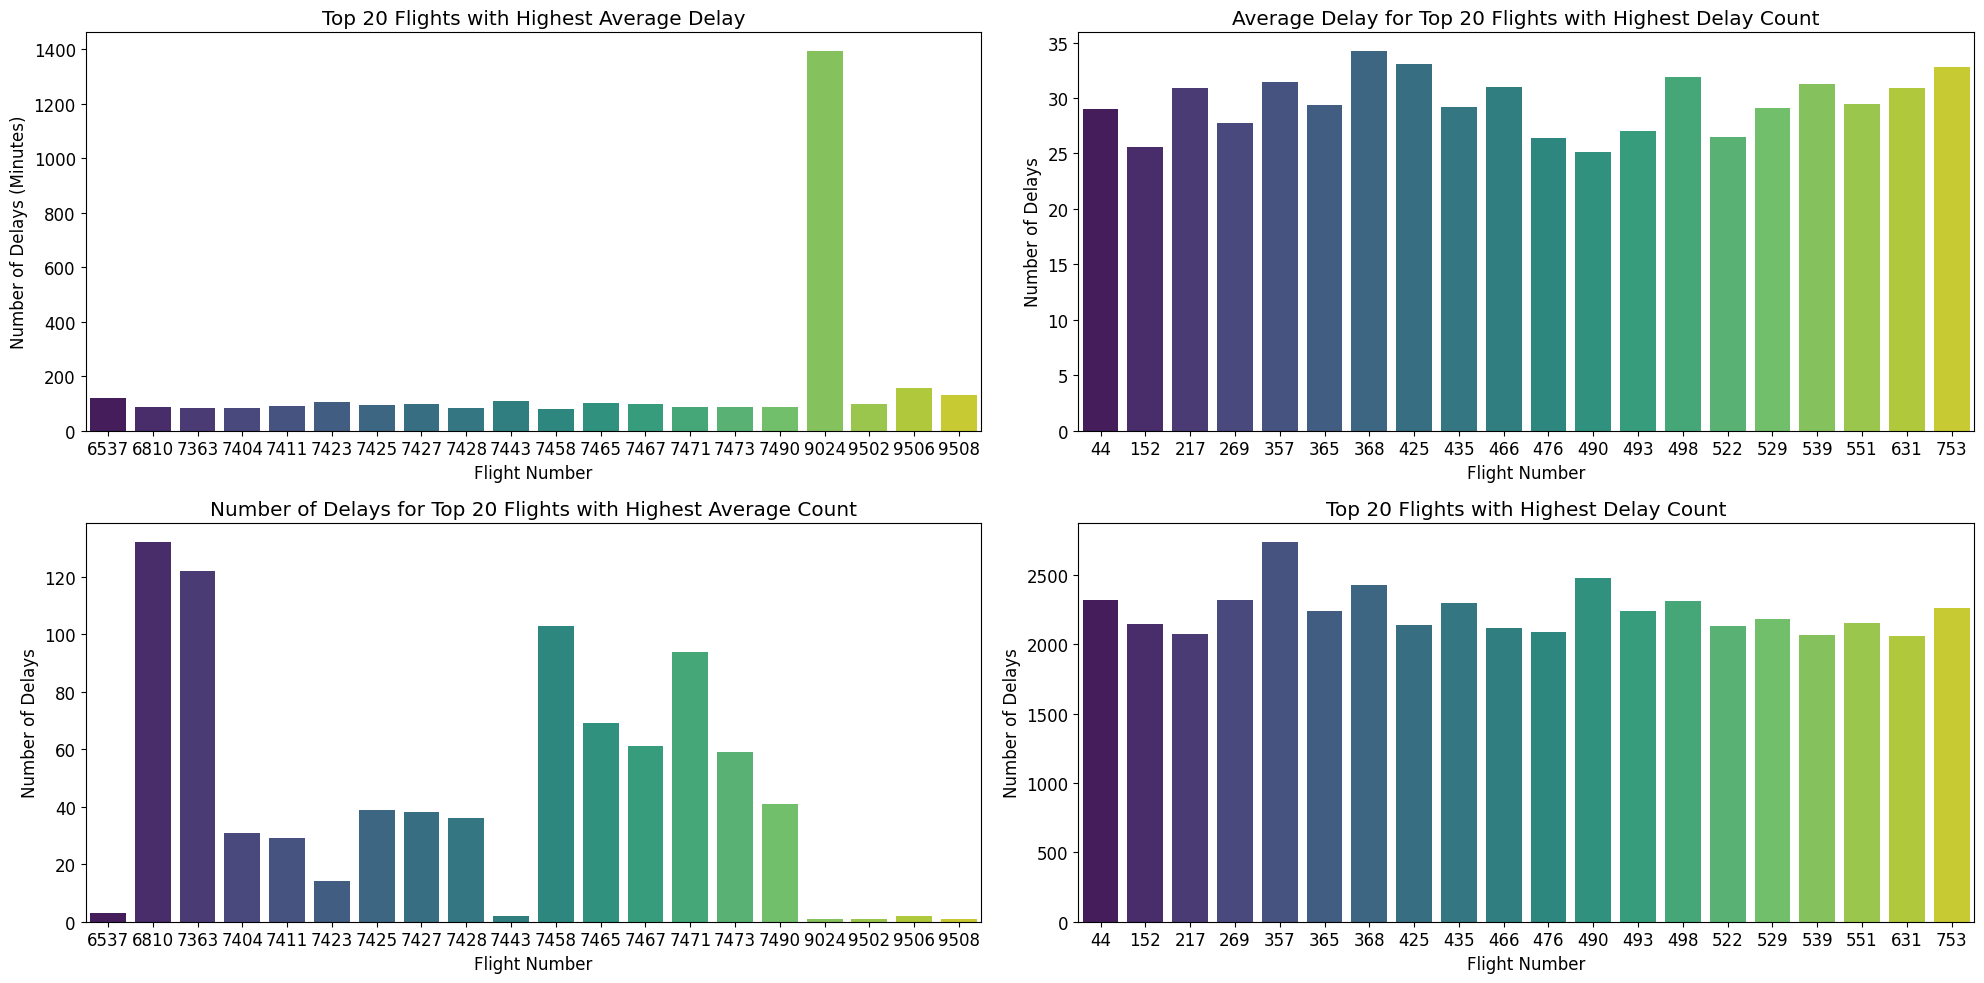

In [60]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
sns.barplot(data=top_20_avg_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
plt.title('Top 20 Flights with Highest Average Delay')
plt.ylabel('Number of Delays (Minutes)')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 2)
sns.barplot(data=top_20_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
plt.title('Average Delay for Top 20 Flights with Highest Delay Count')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 3)
sns.barplot(data=top_20_avg_delays, y='delay_count', x='flightnum', palette='viridis')
plt.title('Number of Delays for Top 20 Flights with Highest Average Count')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 4)
sns.barplot(data=top_20_delays, y='delay_count', x='flightnum', palette='viridis')
plt.title('Top 20 Flights with Highest Delay Count')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.tight_layout()
plt.show();

<ipython-input-61-3a8c460ad641>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_cancellations, y='cancellation_count', x='flightnum', palette='viridis')


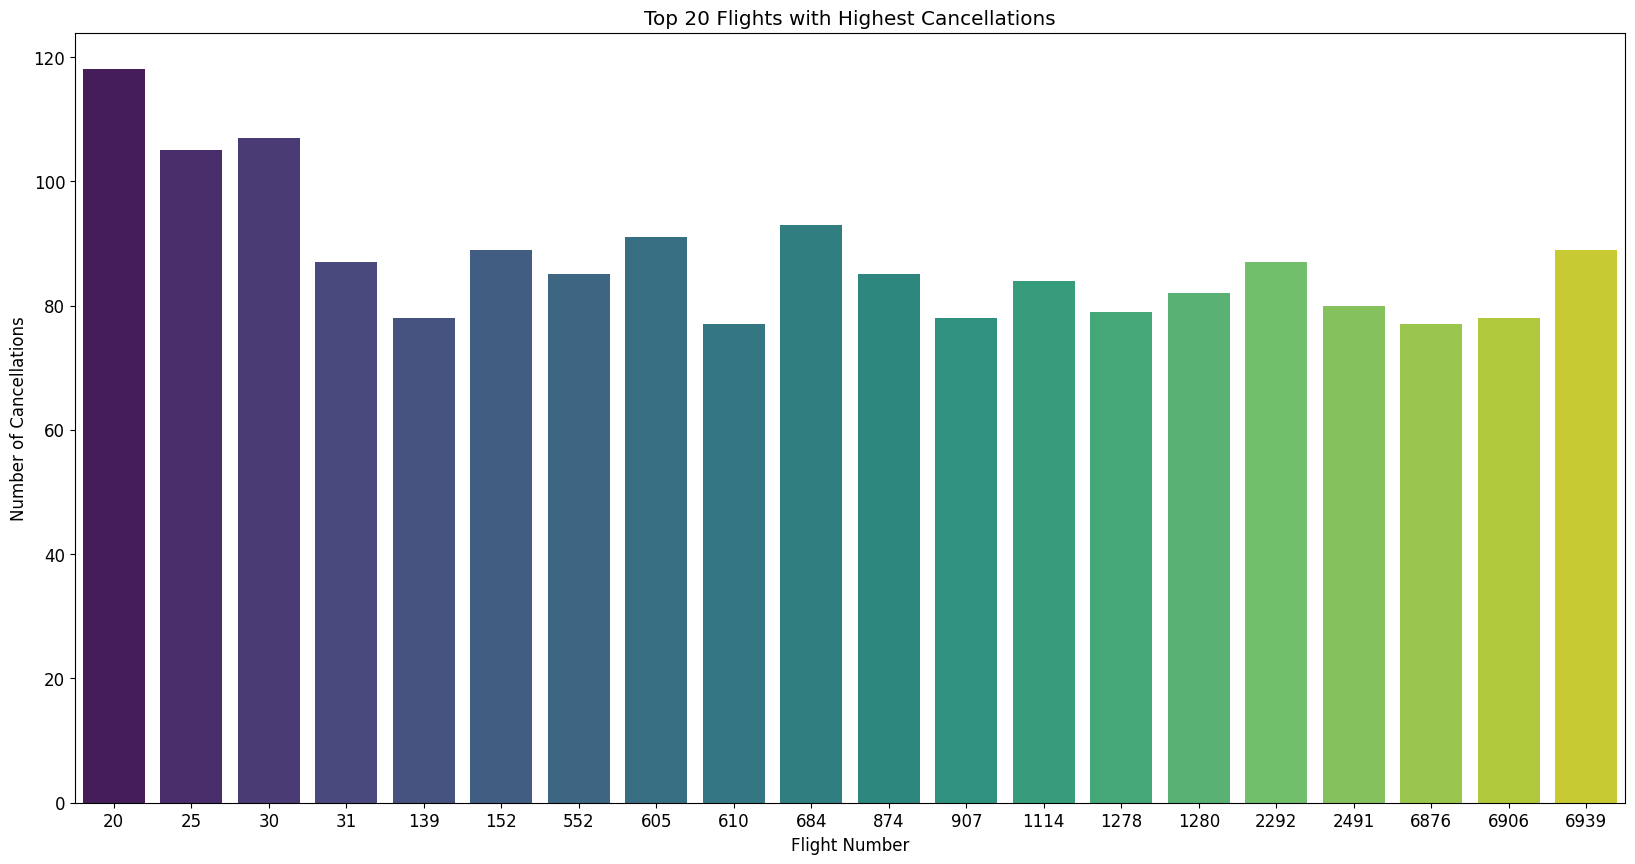

In [61]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 10})

sns.barplot(data=top_20_cancellations, y='cancellation_count', x='flightnum', palette='viridis')
plt.title('Top 20 Flights with Highest Cancellations')
plt.ylabel('Number of Cancellations')
plt.xlabel('Flight Number')

plt.show();

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [37]:
features = flights[['CRSDepTime', 'DayOfWeek', 'Month', 'Distance']]
target = flights['Cancelled']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)

In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [39]:
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [40]:
y_pred = logistic_model.predict(X_test)

In [41]:
# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}');

Accuracy: 0.49


In [42]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix);

Confusion Matrix:
[[1019498 1086517]
 [  11931   24631]]


In [43]:
# Print the classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report);

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.48      0.65   2106015
           1       0.02      0.67      0.04     36562

    accuracy                           0.49   2142577
   macro avg       0.51      0.58      0.35   2142577
weighted avg       0.97      0.49      0.64   2142577



In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare data
features = flights[['CRSDepTime', 'DayOfWeek', 'DayOfMonth', 'Month', 'Distance']]
target = flights['Cancelled']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.021432871310595885


In [48]:
y_pred

array([0.        , 0.        , 0.        , ..., 0.38671429, 0.62880556,
       0.        ])